# Analyses of model predictions and feature weights

In [1]:
import os, sys
import pandas as pd
import numpy as np

# df=pd.read_csv(os.path.join("..",
#                             "..",
#                             "rawdata",
#                             "OP_extended_AKD2.csv"
#                            ),
#                index_col=0
#               )

# #Rearranging 
# # columns=df.columns.values
# # columns[-1]="logki"
# # df.columns=columns
# # columns=columns[1:-1]
# # columns=np.insert(columns, 0, "logki")
# # df=df[columns]

# feat_id=7

# df=df.drop(index=[865,866,867])

# #Replace 999 and -999 (eDragon errors) with np.nan
# df=df.replace(to_replace=999, value=np.nan)

# # Remove error columns
# n_na = np.sum(df.iloc[:, feat_id:].isnull(), axis=0)
# drop_col = df.columns[np.where(n_na > 0)[0]+feat_id]
# df = df.drop(columns=drop_col)
# print(f"{len(drop_col)} out of {len(n_na)} features dropped")
# print(drop_col)

# all_features = df.iloc[:, feat_id:]
# all_target = df['logki']

# species_list=np.unique(df['Species'], return_counts=True)
# print(species_list[0], species_list[1])
# #Drop rows with 10 or less chemicals tested in the same species
# retained_species_list=species_list[0][np.argwhere(species_list[1]>10)].flatten()
# species_mask=np.isin(df['Species'], retained_species_list)

# df_new=df[species_mask]

# valid_target_mask = ~np.isnan(df_new['Normalized_temp_logki'])
# df_new = df_new[valid_target_mask]

# OHE=pd.get_dummies(df_new['Species'])

# all_features=df_new.iloc[:, feat_id:]
# all_features=pd.concat([OHE, all_features], 
#                        axis=1)
# id_df=df_new.iloc[:, :feat_id]
# # all_target=df_new['logki']
# all_target = df_new['Normalized_temp_logki']

In [2]:
from AChEi_experiment_helper import load_data
r = load_data()
all_features=r['valid_features']
all_target = r['valid_target']
Fweights = r['valid_Fweights']

## Load helper functions

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.backend.set_floatx('float32')


code_folder=os.path.join(os.getcwd(),
                         "..",
                         "..",
                         "0_code"
                        )
sys.path.append(code_folder)



In [4]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import l1, l2
from functools import partial 
import dill as pickle

from algorithms import attention_model
from AChEi_experiment_helper import _get_model
# def _get_model(model_type,
# 			   n_attention,
# 			   n_attention_hidden,
# 			   n_feat,
# 			   n_out,
# 			   n_concat_hidden,
# 			   concat_activation,
# 			   n_attention_out,
# 			   kernel_initializer,
# 			   bias_initializer,
# 			   attention_kernel_initializer,
# 			   attention_bias_initializer,
# 			   attention_hidden_activation,
# 			   attention_output_activation,
# 			   n_hidden,
# 			   hidden_activation,
# 			   kernel_regularizer,
# 			   bias_regularizer,
# 			   random_seed=123):
# 	tf.random.set_seed(random_seed)
# 	if model_type == "LSwFW" or model_type == "LSwFW_ones":
# 		input_shape = (n_feat*2,)
# 	else:
# 		input_shape = (n_feat,)
# 	input_layer = Input(shape=input_shape)

# 	if model_type == "dense":
# 		print(f"First dense layer with {n_attention*n_attention_hidden*n_attention_out} hidden units")
# 		first_layer = Dense(n_attention*n_attention_hidden*n_attention_out,
# 							activation=hidden_activation,
# 							kernel_initializer=kernel_initializer,
# 							kernel_regularizer=kernel_regularizer,
# 							bias_initializer=bias_initializer,
# 							bias_regularizer=bias_regularizer,
# 							)(input_layer)

# 		layer0 = Dense(n_concat_hidden,
# 					   activation=hidden_activation,
# 					   kernel_initializer=kernel_initializer,
# 					   kernel_regularizer=kernel_regularizer,
# 					   bias_initializer=bias_initializer,
# 					   bias_regularizer=bias_regularizer,
# 					   )(first_layer)
# 	elif model_type == "LS":
# 		layer0 = attention_model.ConcatAttentions(
# 			n_attention=n_attention,
# 			n_attention_hidden=n_attention_hidden,
# 			n_attention_out=n_attention_out,
# 			n_feat=n_feat,
# 			n_hidden=n_concat_hidden,
# 			activation=concat_activation,
# 			kernel_initializer=kernel_initializer,
# 			bias_initializer=bias_initializer,
# 			kernel_regularizer=l2(1E-5),
# 			bias_regularizer=l2(1E-5),
# 			attention_kernel_initializer=attention_kernel_initializer,
# 			attention_bias_initializer=attention_bias_initializer,
# 			attention_hidden_activation=attention_hidden_activation,
# 			attention_output_activation=attention_output_activation,
# 			batch_norm_kwargs={"trainable": False, "renorm": True},
# 		)(input_layer)
# 	elif model_type == "LSwFW":
# 		layer0 = attention_model.ConcatAttentionswFeatWeights(
# 			n_attention=n_attention,
# 			n_attention_hidden=n_attention_hidden,
# 			n_attention_out=n_attention_out,
# 			n_feat=n_feat,
# 			n_hidden=n_concat_hidden,
# 			activation=concat_activation,
# 			kernel_initializer=kernel_initializer,
# 			bias_initializer=bias_initializer,
# 			kernel_regularizer=l2(1E-5),
# 			bias_regularizer=l2(1E-5),
# 			attention_kernel_initializer=kernel_initializer,
# 			attention_bias_initializer=bias_initializer,
# 			attention_hidden_activation=attention_hidden_activation,
# 			attention_output_activation=attention_output_activation,
# 			batch_norm_kwargs={"trainable": False, "renorm": True},
# 		)(input_layer)
# 	dense_layer1 = Dense(n_hidden,
# 						 activation=hidden_activation,
# 						 kernel_initializer=kernel_initializer,
# 						 kernel_regularizer=kernel_regularizer,
# 						 bias_initializer=bias_initializer,
# 						 bias_regularizer=bias_regularizer,
# 						 )(layer0)
# 	dropout1 = Dropout(0.1)(dense_layer1)
# 	batchnorm1 = BatchNormalization(trainable=False,
# 									renorm=True
# 									)(dropout1)
# 	dense_layer2 = Dense(n_hidden,
# 						 activation=hidden_activation,
# 						 kernel_initializer=kernel_initializer,
# 						 kernel_regularizer=kernel_regularizer,
# 						 bias_initializer=bias_initializer,
# 						 bias_regularizer=bias_regularizer
# 						 )(batchnorm1)
# # 	dropout2 = Dropout(0.1)(dense_layer2)
# # 	batchnorm2 = BatchNormalization(trainable=False,
# # 									renorm=True
# # 									)(dropout2)
# # 	dense_layer3 = Dense(n_hidden,
# # 						 activation=hidden_activation,
# # 						 kernel_initializer=kernel_initializer,
# # 						 kernel_regularizer=kernel_regularizer,
# # 						 bias_initializer=bias_initializer,
# # 						 bias_regularizer=bias_regularizer,
# # 						 )(batchnorm2)
# 	output_layer = Dense(n_out, activation="linear")(dense_layer2)

# 	tf_model = tf.keras.Model(inputs=input_layer,
# 							  outputs=output_layer
# 							  )
# 	return tf_model

# def get_dense_model(**kwargs):
# 	model_type = "dense"
# 	return _get_model(model_type,
# 					  **kwargs
# 					  )
# def get_attention_model(**kwargs):
# 	model_type = "LS"
# 	return _get_model(model_type,
# 					  **kwargs)


# def get_attentionwFW_model(**kwargs):
# 	model_type = "LSwFW"
# 	return _get_model(model_type,
# 					  **kwargs
# 					  )


## Load model

In [5]:
# RobustScaler target scaler (instead of MinMax)
from sklearn.preprocessing import StandardScaler, RobustScaler
from AChEi_experiment_helper import data_scaling, get_model_setup_params, get_model_compile_params



from sklearn.preprocessing import StandardScaler, MinMaxScaler
# #Convenience function for loading indices, Fweights and scaling
# def load_splits(model_folder, 
#                 all_features=all_features,
#                 all_target=all_target, 
#                ):
#     with open(os.path.join(model_folder, "input_info.ob"), 'rb') as f:
#         to_load = pickle.load(f)
# #     final_selected_feat_ind = to_load['final_selected_feat_ind']
#     train_ind, test_ind = to_load['train_ind'], to_load['test_ind']
#     train_features = all_features.iloc[train_ind, :].values
#     test_features = all_features.iloc[test_ind, :].values
#     train_target = all_target.iloc[train_ind].values
#     test_target = all_target.iloc[test_ind].values
    
# #     train_features = all_features.iloc[train_ind,:].values
# #     test_features = all_features.iloc[test_ind,:].values
# #     train_target = all_target[train_ind]
# #     test_target = all_target[test_ind]
# #     train_Fweights = to_load['train_Fweights']
# #     test_Fweights = to_load['test_Fweights']

#     # Scaling
#     feature_scaler = StandardScaler()
# #     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
#     target_scaler = RobustScaler()
    
#     _ = data_scaling(feature_scaler, 
#                  target_scaler, 
#                  train_features, 
#                  test_features, 
#                  train_target,
#                  test_target)
#     train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler=_
        

# #     train_tensor_scaled = np.hstack([train_features_scaled, train_Fweights])
# #     test_tensor_scaled = np.hstack([test_features_scaled, test_Fweights])
    
#     return test_target, test_features_scaled, target_scaler, train_target, train_features_scaled

In [6]:
_idx=0

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
import pickle
model_type="dense"

load_dense_model_results=[]
dense_train_errors=[]
dense_test_errors=[]
dense_test_predict=[]
test_targets=[]

super_folder = os.path.join("AChEi_extendedDataset_models",
                            "210505_Dense"
                           )
folder_prefix = "210505_dense_RobustScaler_tempNormKi_AChEi_extendedDataset_allFeatures_split"
from sklearn.model_selection import KFold
kf = KFold(n_splits=20, random_state=1234, shuffle=True)
for split_idx, (train_ind, test_ind) in enumerate(kf.split(all_features)):
    if split_idx<_idx:
        continue
    model_folder = os.path.join(super_folder, 
                                folder_prefix+f"{split_idx:02d}"
                               )
    checkpoint_path = os.path.join(model_folder,
                                   "model_checkpoint"
                                   )    
    train_features = all_features.iloc[train_ind, :].values
    test_features = all_features.iloc[test_ind, :].values
    train_target = all_target.iloc[train_ind].values
    test_target = all_target.iloc[test_ind].values
    
    feature_scaler = StandardScaler()
#     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    target_scaler = RobustScaler()
    
    _ = data_scaling(feature_scaler, 
                 target_scaler, 
                 train_features, 
                 test_features, 
                 train_target,
                 test_target)
    train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler=_
    
    model_setup_params = get_model_setup_params()
    model_setup_params['n_feat']=train_features_scaled.shape[1]
    model_compile_params = get_model_compile_params(0.5)
    
    load_dense_model=_get_model(model_type=model_type, 
                                **model_setup_params
                               )
    load_dense_model.compile(**model_compile_params)
    # Evaluate model
    load_dense_model.load_weights(checkpoint_path)
    test_predict = target_scaler.inverse_transform(
        load_dense_model(test_features_scaled).numpy()
    ).flatten()

    rmse = mean_squared_error(test_target, test_predict, squared=False)

    r2 = r2_score(test_target, test_predict, )
    print(f"Split{split_idx}: RMSE = {rmse:.3f}; R^2 = {r2:.3f}.")

    load_dense_model_results.append(["dense_model", split_idx, "RMSE", rmse])
    load_dense_model_results.append(["dense_model", split_idx, "Rsquared", r2])
    
    #Get instances of misclassification
    train_predict = target_scaler.inverse_transform(
    load_dense_model(train_features_scaled).numpy()
).flatten()
    dense_train_errors.append(np.where(np.abs(train_target-train_predict)>1)[0])
    dense_test_errors.append(np.where(np.abs(test_target-test_predict)>1)[0])
    dense_test_predict.append(test_predict)
    test_targets.append(test_target)
    
dense_df = pd.DataFrame(load_dense_model_results,
                        columns = ["Model", "split", "Metric", "score"]
                       )
r2_scores=dense_df.query("Metric=='Rsquared'")['score']
print(f"Dense model {np.mean(r2_scores):.3f} +/- {np.std(r2_scores):.3f}")

First dense layer with 15360 hidden units
Split0: RMSE = 0.501; R^2 = 0.919.
First dense layer with 15360 hidden units
Split1: RMSE = 0.649; R^2 = 0.878.
First dense layer with 15360 hidden units
Split2: RMSE = 0.763; R^2 = 0.818.
First dense layer with 15360 hidden units
Split3: RMSE = 0.697; R^2 = 0.882.
First dense layer with 15360 hidden units
Split4: RMSE = 0.613; R^2 = 0.869.
First dense layer with 15360 hidden units
Split5: RMSE = 0.533; R^2 = 0.886.
First dense layer with 15360 hidden units
Split6: RMSE = 0.641; R^2 = 0.825.
First dense layer with 15360 hidden units
Split7: RMSE = 0.556; R^2 = 0.901.
First dense layer with 15360 hidden units
Split8: RMSE = 0.911; R^2 = 0.682.
First dense layer with 15360 hidden units
Split9: RMSE = 0.600; R^2 = 0.894.
First dense layer with 15360 hidden units


Split10: RMSE = 0.663; R^2 = 0.842.
First dense layer with 15360 hidden units
Split11: RMSE = 0.489; R^2 = 0.905.
First dense layer with 15360 hidden units
Split12: RMSE = 0.509; R^2 = 0.893.
First dense layer with 15360 hidden units
Split13: RMSE = 0.461; R^2 = 0.881.
First dense layer with 15360 hidden units
Split14: RMSE = 0.609; R^2 = 0.891.
First dense layer with 15360 hidden units
Split15: RMSE = 0.441; R^2 = 0.944.
First dense layer with 15360 hidden units
Split16: RMSE = 0.526; R^2 = 0.837.
First dense layer with 15360 hidden units
Split17: RMSE = 0.515; R^2 = 0.898.
First dense layer with 15360 hidden units
Split18: RMSE = 0.507; R^2 = 0.894.
First dense layer with 15360 hidden units
Split19: RMSE = 0.660; R^2 = 0.866.
Dense model 0.870 +/- 0.053


<AxesSubplot:>

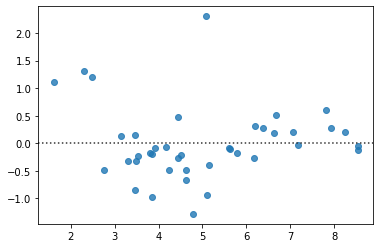

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

sns.residplot(x=test_predict, y = test_target-test_predict, 
             )

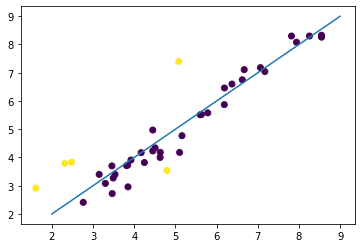

In [9]:
plt.scatter(test_predict, test_target, 
            c = np.abs(test_target-test_predict)>1)
plt.plot([2,9],[2,9])

<AxesSubplot:>

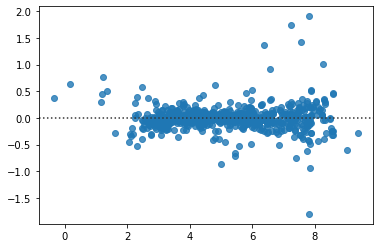

In [10]:
train_predict = target_scaler.inverse_transform(
    load_dense_model(train_features_scaled).numpy()
).flatten()
sns.residplot(x=train_predict, y = train_target-train_predict, 
             )

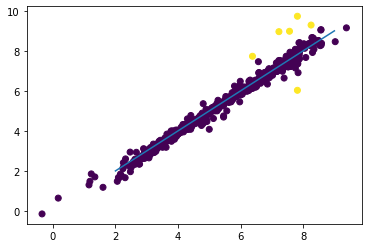

In [11]:
plt.scatter(train_predict, train_target, 
            c = np.abs(train_target-train_predict)>1)
plt.plot([2,9],[2,9])

In [12]:
dense_train_error=np.where(np.abs(train_target-train_predict)>1)
dense_test_error = np.where(np.abs(test_target-test_predict)>1)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import pickle
model_type="LSwFW_ones"

load_LSwFW_model_results=[]
LSwFW_train_errors=[]
LSwFW_test_errors=[]
LSwFW_test_predict=[]

super_folder = os.path.join("AChEi_extendedDataset_models",
                            "210505_LSwFW_ones"
                           )
folder_prefix = "210505_LSwFW_ones_RobustScaler_tempNormKi_AChEi_extendedDataset_allFeatures_split"
from sklearn.model_selection import KFold
kf = KFold(n_splits=20, random_state=1234, shuffle=True)
for split_idx, (train_ind, test_ind) in enumerate(kf.split(all_features)):
    if split_idx<_idx:
        continue
    model_folder = os.path.join(super_folder, 
                                folder_prefix+f"{split_idx:02d}"
                               )
    checkpoint_path = os.path.join(model_folder,
                                   "model_checkpoint"
                                   )    
    train_features = all_features.iloc[train_ind, :].values
    test_features = all_features.iloc[test_ind, :].values
    train_target = all_target.iloc[train_ind].values
    test_target = all_target.iloc[test_ind].values
    
    feature_scaler = StandardScaler()
#     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    target_scaler = RobustScaler()
    
    _ = data_scaling(feature_scaler, 
                 target_scaler, 
                 train_features, 
                 test_features, 
                 train_target,
                 test_target)
    train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler=_
    
    model_setup_params = get_model_setup_params()
    model_setup_params['n_feat']=train_features_scaled.shape[1]
    model_compile_params = get_model_compile_params(0.5)
    
    if model_type=="LSwFW_ones":
        train_features_scaled = np.hstack([
            train_features_scaled, 
            np.ones_like(train_features_scaled)
                                          ])
        test_features_scaled = np.hstack([
            test_features_scaled,
            np.ones_like(test_features_scaled)
        ])
    
    load_LSwFW_model=_get_model(model_type=model_type, 
                                **model_setup_params
                               )
    load_LSwFW_model.compile(**model_compile_params)
    # Evaluate model
    load_LSwFW_model.load_weights(checkpoint_path)
    test_predict = target_scaler.inverse_transform(
        load_LSwFW_model(test_features_scaled).numpy()
    ).flatten()

    rmse = mean_squared_error(test_target, test_predict, squared=False)

    r2 = r2_score(test_target, test_predict, )
    print(f"Split{split_idx}: RMSE = {rmse:.3f}; R^2 = {r2:.3f}.")

    load_LSwFW_model_results.append(["LSwFW_ones_model", split_idx, "RMSE", rmse])
    load_LSwFW_model_results.append(["LSwFW_ones_model", split_idx, "Rsquared", r2])
    #Get instances of misclassification
    train_predict = target_scaler.inverse_transform(
        load_LSwFW_model(train_features_scaled).numpy()
).flatten()
    LSwFW_train_errors.append(np.where(np.abs(train_target-train_predict)>1)[0])
    LSwFW_test_errors.append(np.where(np.abs(test_target-test_predict)>1)[0])
    LSwFW_test_predict.append(test_predict)
    
LSwFW_df = pd.DataFrame(load_LSwFW_model_results,
                        columns = ["Model", "split", "Metric", "score"]
                       )
r2_scores=LSwFW_df.query("Metric=='Rsquared'")['score']
print(f"LSwFW model {np.mean(r2_scores):.3f} +/- {np.std(r2_scores):.3f}")

Split0: RMSE = 0.602; R^2 = 0.883.
Split1: RMSE = 0.601; R^2 = 0.895.
Split2: RMSE = 0.837; R^2 = 0.781.
Split3: RMSE = 0.749; R^2 = 0.863.
Split4: RMSE = 0.509; R^2 = 0.910.
Split5: RMSE = 0.626; R^2 = 0.843.
Split6: RMSE = 0.647; R^2 = 0.822.
Split7: RMSE = 0.563; R^2 = 0.899.
Split8: RMSE = 0.932; R^2 = 0.667.
Split9: RMSE = 0.611; R^2 = 0.889.
Split10: RMSE = 0.639; R^2 = 0.854.


Split11: RMSE = 0.456; R^2 = 0.918.
Split12: RMSE = 0.492; R^2 = 0.900.
Split13: RMSE = 0.439; R^2 = 0.893.
Split14: RMSE = 0.579; R^2 = 0.902.
Split15: RMSE = 0.476; R^2 = 0.935.
Split16: RMSE = 0.519; R^2 = 0.841.
Split17: RMSE = 0.515; R^2 = 0.898.
Split18: RMSE = 0.552; R^2 = 0.874.
Split19: RMSE = 0.697; R^2 = 0.851.
LSwFW model 0.866 +/- 0.058


### Plots for a single fold (Please Ignore)

<AxesSubplot:>

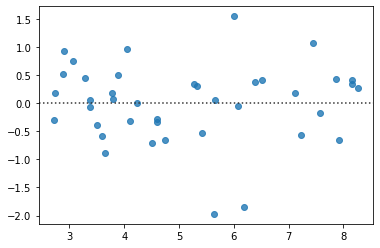

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

sns.residplot(x=test_predict, y = test_target-test_predict, 
             )

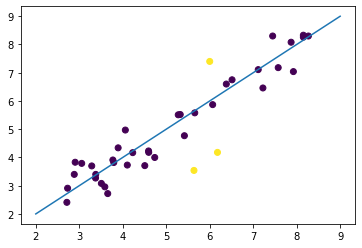

In [15]:
plt.scatter(test_predict, test_target, 
            c = np.abs(test_target-test_predict)>1)
plt.plot([2,9],[2,9])

<AxesSubplot:>

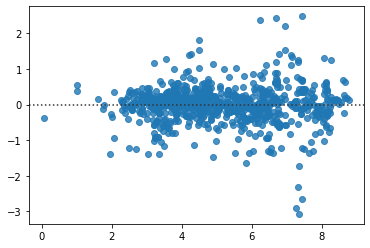

In [16]:
train_predict = target_scaler.inverse_transform(
    load_LSwFW_model(train_features_scaled).numpy()
).flatten()
sns.residplot(x=train_predict, y = train_target-train_predict, 
             )


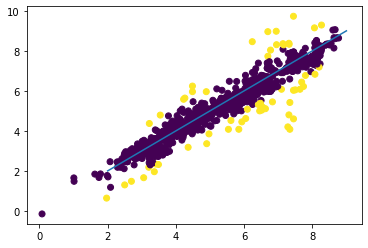

In [17]:
plt.scatter(train_predict, train_target, 
            c = np.abs(train_target-train_predict)>1)
plt.plot([2,9],[2,9])

In [18]:
ls_train_error=np.where(np.abs(train_target-train_predict)>1)
ls_test_error = np.where(np.abs(test_target-test_predict)>1)

Text(0.5, 1.0, 'Training errors (Delta LogKi > 1)')

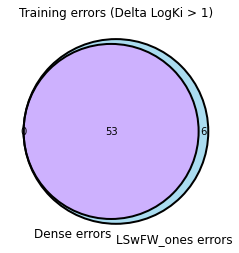

In [19]:
# from matplotlib_venn import venn2, venn2_circles
# overlap=np.intersect1d(dense_train_error, ls_train_error)
# ls_only = np.setdiff1d(ls_train_error, overlap)
# dense_only = np.setdiff1d(dense_train_error, overlap)
# subsets = (len(dense_only), 
#                  len(overlap), 
#                  len(ls_only))
# venn2(subsets = subsets,
#       set_labels=("Dense errors", "LSwFW_ones errors"),
#       set_colors=("purple", "skyblue"), 
#       alpha=0.7
#                 )
# venn2_circles(subsets=subsets)
# plt.title("Training errors (Delta LogKi > 1)")

Text(0.5, 1.0, 'Testing errors (Delta LogKi > 1)')

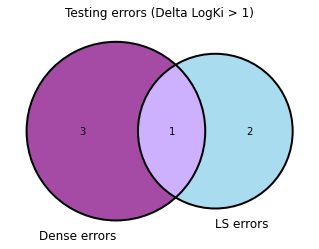

In [23]:
from matplotlib_venn import venn2, venn2_circles
overlap=np.intersect1d(dense_test_error, ls_test_error)
ls_only = np.setdiff1d(ls_test_error, overlap)
dense_only = np.setdiff1d(dense_test_error, overlap)
subsets = (len(dense_only), 
                 len(overlap), 
                 len(ls_only))
venn2(subsets = subsets,
      set_labels=("Dense errors", "LS errors"),
      set_colors=("purple", "skyblue"), 
      alpha=0.7
                )
venn2_circles(subsets=subsets)
plt.title("Testing errors (Delta LogKi > 1)")

### Plots across all folds

In [24]:
_dense_train_errors=[]
_dense_test_errors=[]
_LSwFW_train_errors=[]
_LSwFW_test_errors=[]
for split_idx, (train_ind, test_ind) in enumerate(kf.split(all_features)):
    _dense_train_errors.append(train_ind[dense_train_errors[split_idx]])
    _dense_test_errors.append(test_ind[dense_test_errors[split_idx]])
    _LSwFW_train_errors.append(train_ind[LSwFW_train_errors[split_idx]])
    _LSwFW_test_errors.append(test_ind[LSwFW_test_errors[split_idx]])

In [25]:
all_dense_train_errors = np.unique(np.concatenate(_dense_train_errors))
all_LSwFW_train_errors=np.unique(np.concatenate(_LSwFW_train_errors))
all_dense_test_errors=np.concatenate(_dense_test_errors)
all_LSwFW_test_errors=np.concatenate(_LSwFW_test_errors)

Text(0.5, 1.0, 'Testing errors (Delta LogKi > 1)')

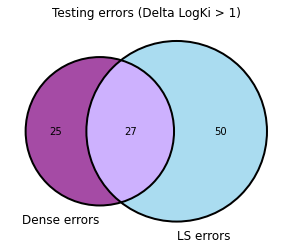

In [26]:
from matplotlib_venn import venn2, venn2_circles
overlap=np.intersect1d(all_dense_test_errors, all_LSwFW_test_errors)
ls_only = np.setdiff1d(all_LSwFW_test_errors, overlap)
dense_only = np.setdiff1d(all_dense_test_errors, overlap)

subsets = (len(dense_only), 
                 len(overlap), 
                 len(ls_only))
venn2(subsets = subsets,
      set_labels=("Dense errors", "LS errors"),
      set_colors=("purple", "skyblue"), 
      alpha=0.7
                )
venn2_circles(subsets=subsets)
plt.title("Testing errors (Delta LogKi > 1)")

Text(0.5, 1.0, 'Training errors (Delta LogKi > 1)')

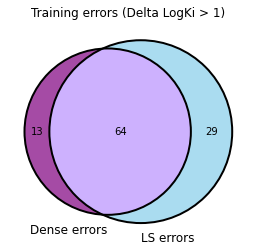

In [27]:
from matplotlib_venn import venn2, venn2_circles
overlap=np.intersect1d(all_dense_train_errors, all_LSwFW_train_errors)
ls_only = np.setdiff1d(all_LSwFW_train_errors, overlap)
dense_only = np.setdiff1d(all_dense_train_errors, overlap)

subsets = (len(dense_only), 
                 len(overlap), 
                 len(ls_only))
venn2(subsets = subsets,
      set_labels=("Dense errors", "LS errors"),
      set_colors=("purple", "skyblue"), 
      alpha=0.7
                )
venn2_circles(subsets=subsets)
plt.title("Training errors (Delta LogKi > 1)")

In [28]:
all_test_targets=np.concatenate(test_targets)
all_dense_test_predict=np.concatenate(dense_test_predict)
all_LSwFW_test_predict=np.concatenate(LSwFW_test_predict)


In [29]:
from sklearn.metrics import r2_score
r2_dense=[r2_score(test_targets[i], dense_test_predict[i]) for i in range(20)]
print(f"Dense cv test R2: {np.mean(r2_dense):.3f} +/- {np.std(r2_dense):.3f}")
r2_LSwFW=[r2_score(test_targets[i], LSwFW_test_predict[i]) for i in range(20)]
print(f"LSwFW cv test R2: {np.mean(r2_LSwFW):.3f} +/- {np.std(r2_LSwFW):.3f}")
r2_averaged=[r2_score(test_targets[i], 
             np.mean([dense_test_predict[i], LSwFW_test_predict[i]], axis=0)
            ) for i in range(20)]
print(f"Averaged cv test R2: {np.mean(r2_averaged):.3f} +/- {np.std(r2_averaged):.3f}")
from scipy.stats import ttest_rel
print(ttest_rel(r2_dense, r2_averaged))
print(ttest_rel(r2_LSwFW, r2_averaged))

Dense cv test R2: 0.870 +/- 0.053
LSwFW cv test R2: 0.866 +/- 0.058
Averaged cv test R2: 0.878 +/- 0.054
Ttest_relResult(statistic=-3.1164329494840404, pvalue=0.00568299839643686)
Ttest_relResult(statistic=-5.050637948456511, pvalue=7.100845424453575e-05)


In [31]:
r2_averaged

[0.9092020552265891,
 0.8930587332408738,
 0.8123108921269717,
 0.8841052844236561,
 0.9008051518236689,
 0.8734638471614041,
 0.8363040211526571,
 0.910588247399843,
 0.6851623484063509,
 0.8952423424154948,
 0.8657152027416337,
 0.9244408543854059,
 0.9098581467825348,
 0.8964258188525962,
 0.9012021321826085,
 0.9477465952390508,
 0.846400230131236,
 0.9066763265310225,
 0.8878068997723987,
 0.8761061864929718]

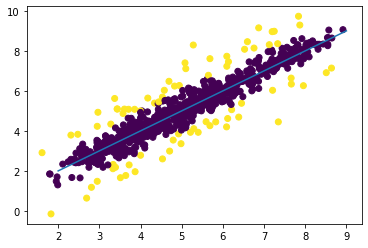

In [40]:

plt.scatter(all_dense_test_predict,
            all_test_targets, 
            c = np.abs(all_test_targets-all_dense_test_predict)>1)
plt.plot([2,9],[2,9])

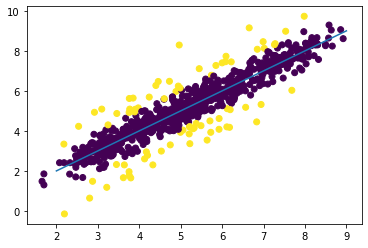

In [54]:
plt.scatter(all_LSwFW_test_predict,
            all_test_targets, 
            c = np.abs(all_test_targets-all_LSwFW_test_predict)>1)
plt.plot([2,9],[2,9])

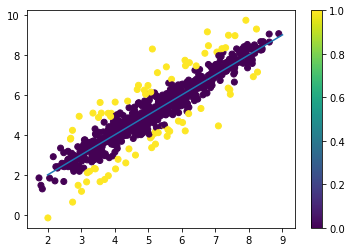

In [59]:
plt.scatter(averaged,
            all_test_targets, 
            c = np.abs(all_test_targets-averaged)>1)
plt.plot([2,9],[2,9])
plt.colorbar()

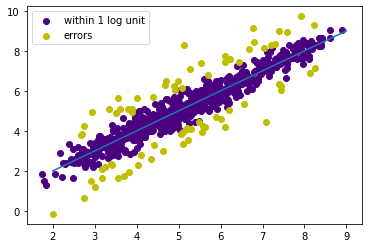

In [73]:
c = np.abs(all_test_targets-averaged)>1
plt.scatter(averaged[c==0],
            all_test_targets[c==0], 
            label="within 1 log unit", c= 'indigo')
plt.scatter(averaged[c==1],
            all_test_targets[c==1], c = 'y',
            label="errors")
plt.plot([2,9],[2,9])
plt.legend()

## Repeat analysis with humanOnly models

In [4]:
import os, sys
import pandas as pd
import numpy as np

from AChEi_experiment_helper import load_data
r = load_data()
valid_features=r['valid_features']
valid_target = r['valid_target']
valid_Fweights = r['valid_Fweights']

rows = np.where(valid_features['A'])[0]
retain_col = range(7, len(valid_features.columns))
all_features = valid_features.iloc[:, retain_col].iloc[rows]
all_target = valid_target.iloc[rows]
all_Fweights = valid_Fweights[np.ix_(rows, retain_col)]

In [9]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.backend.set_floatx('float32')


code_folder=os.path.join(os.getcwd(),
                         "..",
                         "..",
                         "0_code"
                        )
sys.path.append(code_folder)

# RobustScaler target scaler (instead of MinMax)
from sklearn.preprocessing import StandardScaler, RobustScaler
from AChEi_experiment_helper import data_scaling, get_model_setup_params, get_model_compile_params, _get_model



from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import pickle
model_type="dense"

load_dense_model_results=[]
dense_train_errors=[]
dense_test_errors=[]
dense_test_predict=[]
test_targets=[]

super_folder = os.path.join("AChEi_humanOnly_models")
folder_prefix = "210511_dense_RobustScaler_tempNormKi_AChEi_extendedDataset_allFeatures_split"
from sklearn.model_selection import KFold
kf = KFold(n_splits=20, random_state=1234, shuffle=True)
for split_idx, (train_ind, test_ind) in enumerate(kf.split(all_features)):
    model_folder = os.path.join(super_folder, 
                                folder_prefix+f"{split_idx:02d}"
                               )
    checkpoint_path = os.path.join(model_folder,
                                   "model_checkpoint"
                                   )    
    train_features = all_features.iloc[train_ind, :].values
    test_features = all_features.iloc[test_ind, :].values
    train_target = all_target.iloc[train_ind].values
    test_target = all_target.iloc[test_ind].values
    
    feature_scaler = StandardScaler()
#     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    target_scaler = RobustScaler()
    
    _ = data_scaling(feature_scaler, 
                 target_scaler, 
                 train_features, 
                 test_features, 
                 train_target,
                 test_target)
    train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler=_
    
    model_setup_params = get_model_setup_params()
    model_setup_params['n_feat']=train_features_scaled.shape[1]
    model_compile_params = get_model_compile_params(0.5)
    
    load_dense_model=_get_model(model_type=model_type, 
                                **model_setup_params
                               )
    load_dense_model.compile(**model_compile_params)
    # Evaluate model
    load_dense_model.load_weights(checkpoint_path)
    test_predict = target_scaler.inverse_transform(
        load_dense_model(test_features_scaled).numpy()
    ).flatten()

    rmse = mean_squared_error(test_target, test_predict, squared=False)

    r2 = r2_score(test_target, test_predict, )
    print(f"Split{split_idx}: RMSE = {rmse:.3f}; R^2 = {r2:.3f}.")

    load_dense_model_results.append(["dense_model", split_idx, "RMSE", rmse])
    load_dense_model_results.append(["dense_model", split_idx, "Rsquared", r2])
    
    #Get instances of misclassification
    train_predict = target_scaler.inverse_transform(
    load_dense_model(train_features_scaled).numpy()
).flatten()
    dense_train_errors.append(np.where(np.abs(train_target-train_predict)>1)[0])
    dense_test_errors.append(np.where(np.abs(test_target-test_predict)>1)[0])
    dense_test_predict.append(test_predict)
    test_targets.append(test_target)
    
dense_df = pd.DataFrame(load_dense_model_results,
                        columns = ["Model", "split", "Metric", "score"]
                       )
r2_scores=dense_df.query("Metric=='Rsquared'")['score']
print(f"Dense model {np.mean(r2_scores):.3f} +/- {np.std(r2_scores):.3f}")

First dense layer with 15360 hidden units
Split0: RMSE = 0.466; R^2 = 0.916.
First dense layer with 15360 hidden units
Split1: RMSE = 0.296; R^2 = 0.968.
First dense layer with 15360 hidden units
Split2: RMSE = 0.522; R^2 = 0.903.
First dense layer with 15360 hidden units
Split3: RMSE = 0.299; R^2 = 0.972.
First dense layer with 15360 hidden units
Split4: RMSE = 0.402; R^2 = 0.957.
First dense layer with 15360 hidden units
Split5: RMSE = 0.324; R^2 = 0.961.
First dense layer with 15360 hidden units
Split6: RMSE = 0.532; R^2 = 0.891.
First dense layer with 15360 hidden units
Split7: RMSE = 0.527; R^2 = 0.900.
First dense layer with 15360 hidden units
Split8: RMSE = 0.894; R^2 = 0.690.
First dense layer with 15360 hidden units
Split9: RMSE = 0.663; R^2 = 0.907.
First dense layer with 15360 hidden units


Split10: RMSE = 0.607; R^2 = 0.903.
First dense layer with 15360 hidden units
Split11: RMSE = 0.432; R^2 = 0.917.
First dense layer with 15360 hidden units
Split12: RMSE = 0.344; R^2 = 0.941.
First dense layer with 15360 hidden units
Split13: RMSE = 0.267; R^2 = 0.975.
First dense layer with 15360 hidden units
Split14: RMSE = 0.430; R^2 = 0.898.
First dense layer with 15360 hidden units
Split15: RMSE = 0.272; R^2 = 0.976.
First dense layer with 15360 hidden units
Split16: RMSE = 0.361; R^2 = 0.940.
First dense layer with 15360 hidden units
Split17: RMSE = 0.381; R^2 = 0.920.
First dense layer with 15360 hidden units
Split18: RMSE = 0.572; R^2 = 0.840.
First dense layer with 15360 hidden units
Split19: RMSE = 0.832; R^2 = 0.656.
Dense model 0.902 +/- 0.084


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import pickle
model_type="LSwFW_ones"

load_LSwFW_model_results=[]
LSwFW_train_errors=[]
LSwFW_test_errors=[]
LSwFW_test_predict=[]

super_folder = os.path.join("AChEi_humanOnly_models")
folder_prefix = "210512_LSwFW_ones_RobustScaler_tempNormKi_AChEi_extendedDataset_allFeatures_split"
from sklearn.model_selection import KFold
kf = KFold(n_splits=20, random_state=1234, shuffle=True)
for split_idx, (train_ind, test_ind) in enumerate(kf.split(all_features)):
    model_folder = os.path.join(super_folder, 
                                folder_prefix+f"{split_idx:02d}"
                               )
    checkpoint_path = os.path.join(model_folder,
                                   "model_checkpoint"
                                   )    
    train_features = all_features.iloc[train_ind, :].values
    test_features = all_features.iloc[test_ind, :].values
    train_target = all_target.iloc[train_ind].values
    test_target = all_target.iloc[test_ind].values
    
    feature_scaler = StandardScaler()
#     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    target_scaler = RobustScaler()
    
    _ = data_scaling(feature_scaler, 
                 target_scaler, 
                 train_features, 
                 test_features, 
                 train_target,
                 test_target)
    train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler=_
    
    model_setup_params = get_model_setup_params()
    model_setup_params['n_feat']=train_features_scaled.shape[1]
    model_compile_params = get_model_compile_params(0.5)
    
    if model_type=="LSwFW_ones":
        train_features_scaled = np.hstack([
            train_features_scaled, 
            np.ones_like(train_features_scaled)
                                          ])
        test_features_scaled = np.hstack([
            test_features_scaled,
            np.ones_like(test_features_scaled)
        ])
    
    load_LSwFW_model=_get_model(model_type=model_type, 
                                **model_setup_params
                               )
    load_LSwFW_model.compile(**model_compile_params)
    # Evaluate model
    load_LSwFW_model.load_weights(checkpoint_path)
    test_predict = target_scaler.inverse_transform(
        load_LSwFW_model(test_features_scaled).numpy()
    ).flatten()

    rmse = mean_squared_error(test_target, test_predict, squared=False)

    r2 = r2_score(test_target, test_predict, )
    print(f"Split{split_idx}: RMSE = {rmse:.3f}; R^2 = {r2:.3f}.")

    load_LSwFW_model_results.append(["LSwFW_ones_model", split_idx, "RMSE", rmse])
    load_LSwFW_model_results.append(["LSwFW_ones_model", split_idx, "Rsquared", r2])
    #Get instances of misclassification
    train_predict = target_scaler.inverse_transform(
        load_LSwFW_model(train_features_scaled).numpy()
).flatten()
    LSwFW_train_errors.append(np.where(np.abs(train_target-train_predict)>1)[0])
    LSwFW_test_errors.append(np.where(np.abs(test_target-test_predict)>1)[0])
    LSwFW_test_predict.append(test_predict)
    
LSwFW_df = pd.DataFrame(load_LSwFW_model_results,
                        columns = ["Model", "split", "Metric", "score"]
                       )
r2_scores=LSwFW_df.query("Metric=='Rsquared'")['score']
print(f"LSwFW model {np.mean(r2_scores):.3f} +/- {np.std(r2_scores):.3f}")

Split0: RMSE = 0.462; R^2 = 0.917.
Split1: RMSE = 0.338; R^2 = 0.959.
Split2: RMSE = 0.434; R^2 = 0.933.
Split3: RMSE = 0.510; R^2 = 0.918.
Split4: RMSE = 0.367; R^2 = 0.965.
Split5: RMSE = 0.348; R^2 = 0.955.
Split6: RMSE = 0.637; R^2 = 0.843.
Split7: RMSE = 0.478; R^2 = 0.918.
Split8: RMSE = 0.925; R^2 = 0.668.
Split9: RMSE = 0.622; R^2 = 0.918.
Split10: RMSE = 0.781; R^2 = 0.839.


Split11: RMSE = 0.418; R^2 = 0.922.
Split12: RMSE = 0.333; R^2 = 0.944.
Split13: RMSE = 0.271; R^2 = 0.974.
Split14: RMSE = 0.446; R^2 = 0.891.
Split15: RMSE = 0.269; R^2 = 0.976.
Split16: RMSE = 0.395; R^2 = 0.928.
Split17: RMSE = 0.443; R^2 = 0.891.
Split18: RMSE = 0.681; R^2 = 0.774.
Split19: RMSE = 0.771; R^2 = 0.705.
LSwFW model 0.892 +/- 0.084


Text(0.5, 1.0, 'Testing errors (Delta LogKi > 1)')

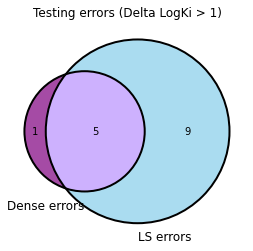

In [15]:
all_dense_train_errors = np.unique(np.concatenate(dense_train_errors))
all_LSwFW_train_errors=np.unique(np.concatenate(LSwFW_train_errors))
all_dense_test_errors=np.concatenate(dense_test_errors)
all_LSwFW_test_errors=np.concatenate(LSwFW_test_errors)

from matplotlib_venn import venn2, venn2_circles
overlap=np.intersect1d(all_dense_test_errors, all_LSwFW_test_errors)
ls_only = np.setdiff1d(all_LSwFW_test_errors, overlap)
dense_only = np.setdiff1d(all_dense_test_errors, overlap)

subsets = (len(dense_only), 
                 len(overlap), 
                 len(ls_only))
venn2(subsets = subsets,
      set_labels=("Dense errors", "LS errors"),
      set_colors=("purple", "skyblue"), 
      alpha=0.7
                )
venn2_circles(subsets=subsets)

import matplotlib.pyplot as plt
plt.title("Testing errors (Delta LogKi > 1)")

In [19]:
r2_dense=[r2_score(test_targets[i], dense_test_predict[i]) for i in range(20)]
print(f"Dense cv test R2: {np.mean(r2_dense):.3f} +/- {np.std(r2_dense):.3f}")
r2_LSwFW=[r2_score(test_targets[i], LSwFW_test_predict[i]) for i in range(20)]
print(f"LSwFW cv test R2: {np.mean(r2_LSwFW):.3f} +/- {np.std(r2_LSwFW):.3f}")
r2_averaged=[r2_score(test_targets[i], 
             np.mean([dense_test_predict[i], LSwFW_test_predict[i]], axis=0)
            ) for i in range(20)]
print(f"Averaged cv test R2: {np.mean(r2_averaged):.3f} +/- {np.std(r2_averaged):.3f}")
print(ttest_rel(r2_dense, r2_averaged))
print(ttest_rel(r2_LSwFW, r2_averaged))

Dense cv test R2: 0.902 +/- 0.084
LSwFW cv test R2: 0.892 +/- 0.084
Averaged cv test R2: 0.909 +/- 0.076
Ttest_relResult(statistic=-1.8659252194796, pvalue=0.07756721060874985)
Ttest_relResult(statistic=-4.282198850279996, pvalue=0.0004023717305220692)


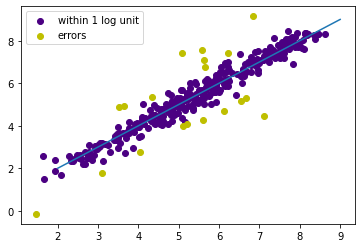

In [23]:
all_test_targets=np.concatenate(test_targets)
all_dense_test_predict=np.concatenate(dense_test_predict)
all_LSwFW_test_predict=np.concatenate(LSwFW_test_predict)
averaged = np.mean([all_dense_test_predict, all_LSwFW_test_predict], axis=0)

c = np.abs(all_test_targets-averaged)>1
plt.scatter(averaged[c==0],
            all_test_targets[c==0], 
            label="within 1 log unit", c= 'indigo')
plt.scatter(averaged[c==1],
            all_test_targets[c==1], c = 'y',
            label="errors")
plt.plot([2,9],[2,9])
plt.legend()

In [18]:
from scipy.stats import ttest_rel
ttest_rel(r2_LSwFW, r2_averaged)

Ttest_relResult(statistic=-4.282198850279996, pvalue=0.0004023717305220692)

## Train model with tensorboard callback

In [30]:
from AChEi_experiment_helper import data_scaling
from AChEi_experiment_helper import get_model_setup_params, get_model_compile_params
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

log_dir="Tensorboard_LS_nobatchnorm_logdir"

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state = 1234)
for train_ind, test_ind in rkf.split(all_features):
    feature_scaler = StandardScaler()
#     target_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    target_scaler = RobustScaler()
    
    train_features = all_features.iloc[train_ind, :]
    test_features = all_features.iloc[test_ind, :]
    train_target = all_target.iloc[train_ind].values
    test_target = all_target.iloc[test_ind].values 
    
    _ = data_scaling(feature_scaler, 
                 target_scaler, 
                 train_features, 
                 test_features, 
                 train_target,
                 test_target)
    train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler=_

    
model_setup_params=get_model_setup_params()
model_setup_params['n_feat']=all_features.shape[1]
model_compile_params = get_model_compile_params(0.05)

model = get_attention_model(**model_setup_params)
model.compile(**model_compile_params)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)
model.fit(train_features_scaled, train_target_scaled, 
          validation_data=(test_features_scaled, test_target_scaled),
          epochs=100,
          shuffle=True, 
          n_batch =8, 
          callbacks=[tensorboard_callback]
         )

Epoch 1/100
25/25 [==============================] - 7s 181ms/step - loss: 0.5872 - mae: 0.5717 - mse: 0.5452 - root_mean_squared_error: 0.7378 - val_loss: 0.4999 - val_mae: 0.4844 - val_mse: 0.3859 - val_root_mean_squared_error: 0.6212
Epoch 2/100
25/25 [==============================] - 1s 39ms/step - loss: 0.4399 - mae: 0.4244 - mse: 0.3166 - root_mean_squared_error: 0.5616 - val_loss: 0.4178 - val_mae: 0.4022 - val_mse: 0.2755 - val_root_mean_squared_error: 0.5249
Epoch 3/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3892 - mae: 0.3737 - mse: 0.2407 - root_mean_squared_error: 0.4904 - val_loss: 0.4793 - val_mae: 0.4638 - val_mse: 0.3842 - val_root_mean_squared_error: 0.6198
Epoch 4/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3420 - mae: 0.3265 - mse: 0.1891 - root_mean_squared_error: 0.4347 - val_loss: 0.4236 - val_mae: 0.4080 - val_mse: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 5/100
25/25 [==============================] - 1s

Epoch 36/100
25/25 [==============================] - 1s 37ms/step - loss: 0.1717 - mae: 0.1562 - mse: 0.0457 - root_mean_squared_error: 0.2136 - val_loss: 0.2943 - val_mae: 0.2788 - val_mse: 0.1328 - val_root_mean_squared_error: 0.3643
Epoch 37/100
25/25 [==============================] - 1s 37ms/step - loss: 0.1664 - mae: 0.1509 - mse: 0.0434 - root_mean_squared_error: 0.2078 - val_loss: 0.2950 - val_mae: 0.2795 - val_mse: 0.1316 - val_root_mean_squared_error: 0.3627
Epoch 38/100
25/25 [==============================] - 1s 37ms/step - loss: 0.1713 - mae: 0.1558 - mse: 0.0450 - root_mean_squared_error: 0.2118 - val_loss: 0.2926 - val_mae: 0.2771 - val_mse: 0.1320 - val_root_mean_squared_error: 0.3633
Epoch 39/100
25/25 [==============================] - 1s 36ms/step - loss: 0.1792 - mae: 0.1637 - mse: 0.0486 - root_mean_squared_error: 0.2203 - val_loss: 0.2856 - val_mae: 0.2701 - val_mse: 0.1299 - val_root_mean_squared_error: 0.3604
Epoch 40/100
25/25 [==============================] 

In [31]:
from sklearn.metrics import r2_score, mean_squared_error
test_predict = target_scaler.inverse_transform(
    model(test_features_scaled).numpy()
).flatten()
rmse = mean_squared_error(test_target, test_predict, squared=False)
r2= r2_score(test_target, test_predict)
print(f"R2 = {r2:.3f}")

R2 = 0.791


In [32]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7184.

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1650)]            0         
_________________________________________________________________
concat_attentions_1 (ConcatA (None, 512)               26009726  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               3584      
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513 

Split0: RMSE = 0.720; R^2 = 0.819.
Dense model 0.819 +/- 0.000


<AxesSubplot:>

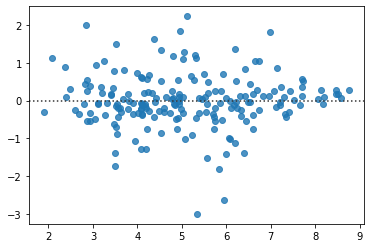

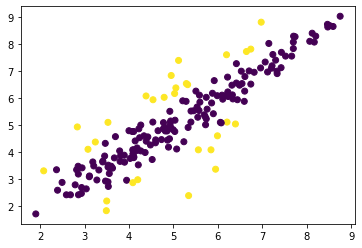

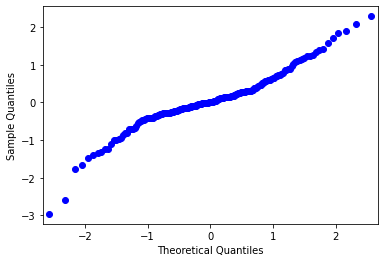

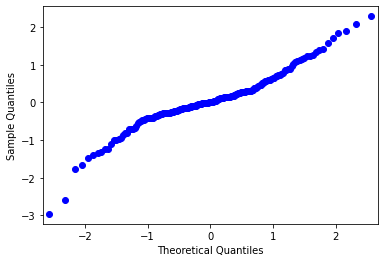

In [37]:
#Q-Q plot of residuas
from statsmodels.graphics.gofplots import qqplot
qqplot(test_target-test_predict)

In [38]:
#Plot Neural network weights
%load_ext tensorboard
import datetime



SyntaxError: invalid syntax (<ipython-input-38-67b0f3d835b0>, line 5)